In [2]:
import numpy as np
import sympy as sp
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import animation
from matplotlib.animation import PillowWriter
# from itertools import combinations
import warnings
warnings.filterwarnings("ignore")

$r_{ij} = r_i - r_j$
$$
U(r_{ij}) = 4\varepsilon [(\sigma/r_{ij})^{12} - (\sigma/r_{ij})^6] \\
U^*(r_{ij}) = 4[(r_{ij}^*)^{-12} - (r_{ij}^*)^{-6}] \\
$$
Force atom $j$ exerts on $i$
$$
\vec{F}^*(r_{ij}) = 48[(r_{ij}^*)^{-6} - 0.5](r_{ij}^*)^{-8} \vec{r_{ij}^*} \\
$$

testing with r as [xs, ys]
[ 5. 13. 25.]
[-0.031744   -0.00181984 -0.00025598]
[[0.0377856  0.00167908 0.0001843 ]
 [0.0755712  0.00251863 0.00024573]]

testing with r as [x matrix, y matrix]
[[ 5. 10. 17.]
 [ 8. 13. 20.]
 [13. 18. 25.]]
[[-0.031744   -0.003996   -0.000814  ]
 [-0.00779724 -0.00181984 -0.00049994]
 [-0.00181984 -0.00068575 -0.00025598]]
[[[0.0377856  0.0023952  0.00028724]
  [0.01167297 0.00167908 0.00029992]
  [0.00251863 0.00068564 0.0001843 ]]

 [[0.0755712  0.0071856  0.00114894]
  [0.01167297 0.00251863 0.00059985]
  [0.00167908 0.00068564 0.00024573]]]


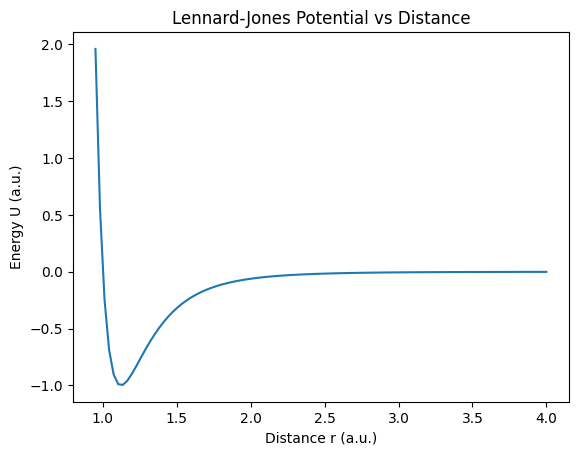

In [31]:
def magnitude2(x):
    return (x*x).sum(axis=0)

def lj_U(x):
    return 4*(x**-6 - 1)*x**-6

def lj_U_vec(r):
    r2 = magnitude2(r)
    return 4*(r2**-3 - 1)*r2**-3

def lj_F_vec(r):
    r2 = magnitude2(r)
    return -48*(r2**-3 - 0.5)*r2**-4 * r

print("testing with r as [xs, ys]")
r = np.array([[1,2,3],[2,3,4]], dtype=float)
print(magnitude2(r))
print(lj_U_vec(r))
print(lj_F_vec(r))

print()
print("testing with r as [x matrix, y matrix]")
rmat = np.array([
    [[1,1,1],[2,2,2],[3,3,3]],
    [[2,3,4],[2,3,4],[2,3,4]],
], dtype=float)
print(magnitude2(rmat))
print(lj_U_vec(rmat))
print(lj_F_vec(rmat))

x = np.linspace(0.95,4,100)
plt.plot(x,lj_U(x))

plt.title("Lennard-Jones Potential vs Distance")
plt.xlabel("Distance r (a.u.)")
plt.ylabel("Energy U (a.u.)")
plt.show()


14.14213562373095


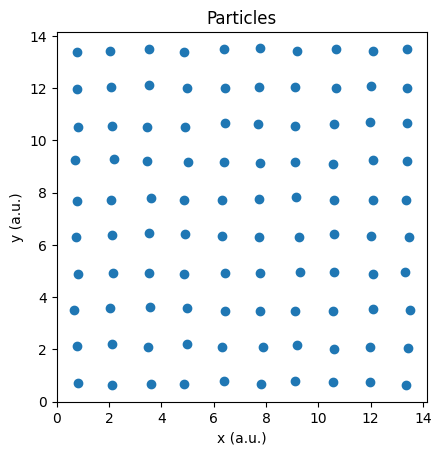

In [99]:
# SET UP RANDOM INITIAL CONDITIONS
rng = np.random.default_rng(seed=102)

X_U_MIN = 2**(1/6)*1
N_L = 10
N = N_L*N_L
DIM = 2

DENSITY = 0.5
LINEAR_DENSITY = DENSITY**(1/DIM)
L = N_L / LINEAR_DENSITY
print(L)

def generate_square_lattice(l,n):
    step = l / n
    # generate matrices of lattice coordinates
    rmat = np.meshgrid(*[np.arange(0,L,step)+step/2 for i in range(DIM)])
    # convert matrices of x and y positions to vectors of x and y positions, and return
    return np.vstack(list(map(np.concatenate,rmat)))

# generate lattice positions
r = generate_square_lattice(L,N_L)
# add small random displacements
r += np.random.uniform(-0.1,0.1,r.shape)

V_SPREAD = 3
v = rng.normal(0, V_SPREAD, (DIM,N))

plt.title("Particles")
plt.xlim(0, L)
plt.ylim(0, L)
plt.xlabel("x (a.u.)")
plt.ylabel("y (a.u.)")
plt.gca().set_aspect('equal')
plt.scatter(*r)
plt.show()

(2, 100, 100)
-2.148631278881605
(2, 100, 100)
(2, 100)


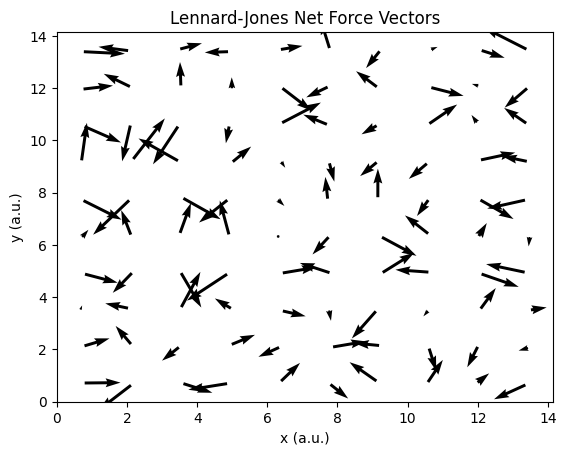

In [122]:
x = r[0]
def pair_displacements_1D(x):
    x = -np.diff(np.meshgrid(x,x),axis=0)[0]
    x = (L/2+x)%L-L/2
    return x

def pair_displacements(r):
    return np.array([pair_displacements_1D(x) for x in r])

def magnitudes(v):
    return np.sqrt(np.sum(v**2,axis=0))

def pair_distances(r):
    return magnitudes(pair_displacements(r))

displacements = pair_displacements(r)

print(displacements.shape)

potential_energies = lj_U_vec(displacements)
potential_energies[~np.isfinite(potential_energies)] = 0
potential_energy = potential_energies.sum()
potential_energy_av = potential_energy / N
print(potential_energy_av)

lj_forces = lj_F_vec(displacements)
lj_forces[np.isnan(lj_forces)] = 0
print(lj_forces.shape)
net_lj_force = lj_forces.sum(axis=2)
print(net_lj_force.shape)

# plt.quiver(np.repeat(r[0],N),np.repeat(r[1],N), displacements[0,:,:].ravel(),displacements[1,:,:].ravel(), angles="xy", scale=1, scale_units="xy")
def plot_each_arrow(r,A,color=None):
    if color is None: color=np.ones(len(A[0])**2)
    return plt.quiver(
        *[np.repeat(x,N)for x in r],
        *[A[i,:,:].ravel() for i in range(DIM)],
        color,
        angles="xy", scale=1, scale_units="xy")
# plot_each_arrow(r,lj_forces,magnitudes(lj_forces))
# plt.show()

# plt.title("Displacement Vectors")
# plt.xlabel("x (a.u.)")
# plt.ylabel("y (a.u.)")
# plot_each_arrow(r,displacements,magnitudes(displacements))
# plt.show()

# plt.title("Lennard-Jones Force Vectors")
# plt.xlim(0, L)
# plt.ylim(0, L)
# plt.xlabel("x (a.u.)")
# plt.ylabel("y (a.u.)")
# plot_each_arrow(
#     r,
#     lj_forces / magnitudes(lj_forces),
#     np.clip(magnitudes(lj_forces),0,1),
# )
# plt.colorbar()
# plt.text(L*0.1,L*0.1, "Forces are clipped with upper bound 1")
# plt.show()

plt.title("Lennard-Jones Net Force Vectors")
plt.xlim(0, L)
plt.ylim(0, L)
plt.xlabel("x (a.u.)")
plt.ylabel("y (a.u.)")
plt.quiver(*r, *net_lj_force, angles="xy", )
plt.show()

In [131]:
def calc_F_lj(r):
    # unit_displacements = pair_displacements(r) / pair_distances(r)
    displacements = pair_displacements(r)
    lj_forces = lj_F_vec(displacements)
    lj_forces[np.isnan(lj_forces)] = 0
    net_lj_force = lj_forces.sum(axis=2)
    return net_lj_force

def calc_a(r):
    F_lj = calc_F_lj(r)
    F_grav = np.array([0,-0.5])
    F = F_lj 
    # F_bounds = calc_F_bounds(r)
    # F += F_bounds
    a = F
    return a

def velocity_verlet(r,v,dt):
    a1 = calc_a(r)
    r = r + v*dt + a1/2 * dt**2
    a2 = calc_a(r)
    v = v + (a1+a2)/2*dt
    return r,v

def wall_boundary_conds(r,v):
    v *= 1 - (np.heaviside(r-L,0) * np.heaviside(v,0))*2
    v *= 1 - (np.heaviside(-r,0) * np.heaviside(-v,0))*2
    return r,v

def periodic_boundary_wrap(r,v):
    r %= L
    return r,v

def boundary_conds(r,v):
    return periodic_boundary_wrap(r,v)

def step_state(r,v,dt):
    r,v = velocity_verlet(r,v,dt)
    r,v = boundary_conds(r,v)
    return r,v

In [132]:
def time_evolution(r,v,steps,dt):
    rs = np.zeros((steps,r.shape[0], r.shape[1]))
    vs = np.zeros((steps,r.shape[0], r.shape[1]))
    for i in range(steps):
        rs[i] = r
        vs[i] = v
        r,v = step_state(r,v,dt)
    return rs, vs

In [133]:
t,dt = 2,0.01
steps = int(t//dt)
rs, vs = time_evolution(r,v,steps,dt)

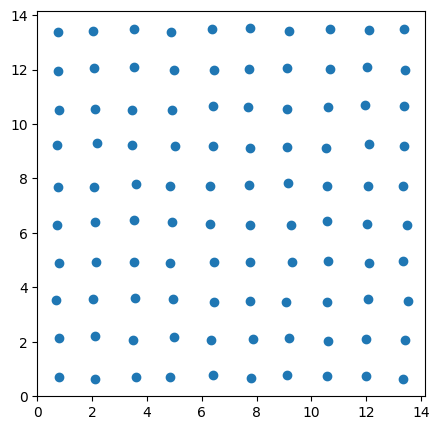

In [134]:
fig, ax = plt.subplots(1,1, figsize=(5,5))
points = ax.scatter(*rs[0])
ax.set_xlim(0, L)
ax.set_ylim(0, L)
def animation_frame(i):
    points.set_offsets(rs[i].T)

lj_anim = animation.FuncAnimation(fig, animation_frame, frames=steps)
lj_anim.save("test.gif", writer="pillow", fps=30, dpi=100)